<a href="https://colab.research.google.com/github/earthlovebpt/myprojects/blob/main/(PyTorch)_intel_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq /content/drive/MyDrive/projects/intel-image-classification/data.zip

In [22]:
import torch
import torchvision
import torch.nn as nn
from torchsummary import summary
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from datetime import datetime
import seaborn as sns

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


# 1. EDA

In [5]:
classes = os.listdir('/content/seg_train/seg_train')
print(classes)

['buildings', 'street', 'glacier', 'forest', 'mountain', 'sea']


In [6]:
train_dir = '/content/seg_train/seg_train'
test_dir = '/content/seg_test/seg_test'

In [7]:
train_dict = {}
for c in classes:
    train_dict[c] = len(os.listdir(train_dir+'/'+c) )
test_dict = {}
for c in classes:
    test_dict[c] = len(os.listdir(test_dir+'/'+c) )

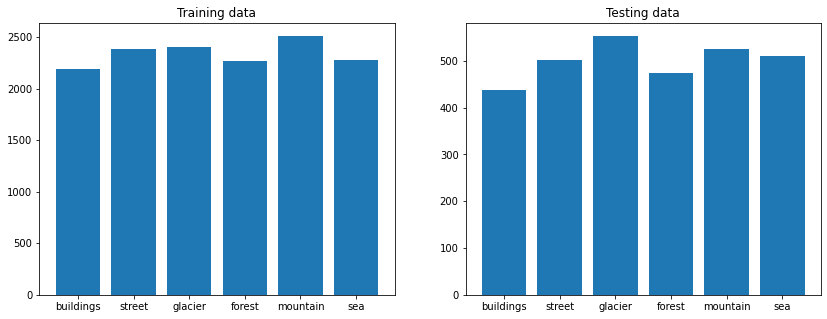

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))
class_img, counts = zip(*train_dict.items())
axes[0].bar(class_img, counts)
axes[0].set_title('Training data')

class_img, counts = zip(*test_dict.items())
axes[1].bar(class_img, counts)
axes[1].set_title('Testing data')
plt.show()

In [11]:
def plot_images(class_img, cols=6, rows=1):
    image_path = train_dir+'/' + class_img
    f = os.listdir(image_path)
    plt.figure(figsize=(2 + 3 * cols, 2 + 4 * rows))
    for i in range(cols * rows):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.title(class_img)
        image = Image.open(f"{image_path}/{f[i]}")
        plt.imshow(image)
    

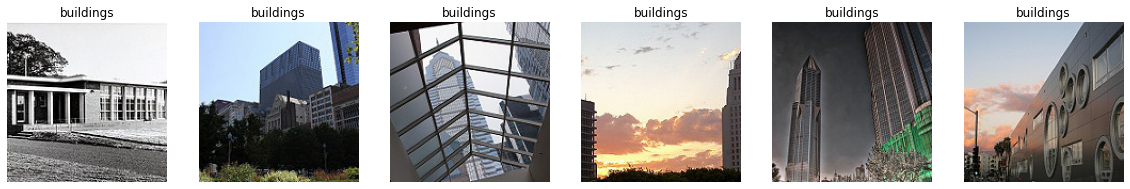

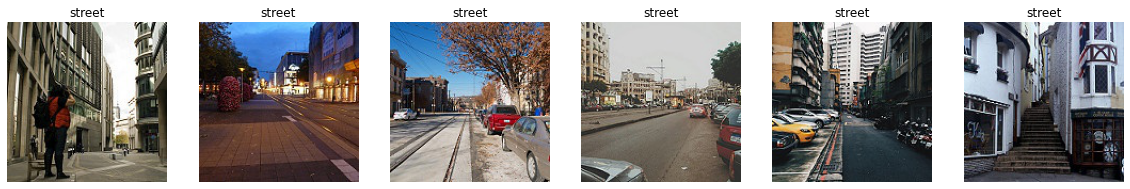

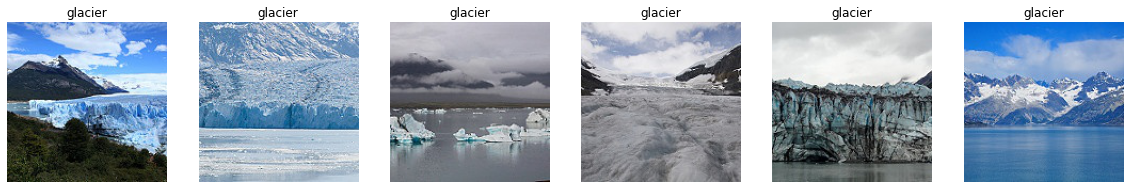

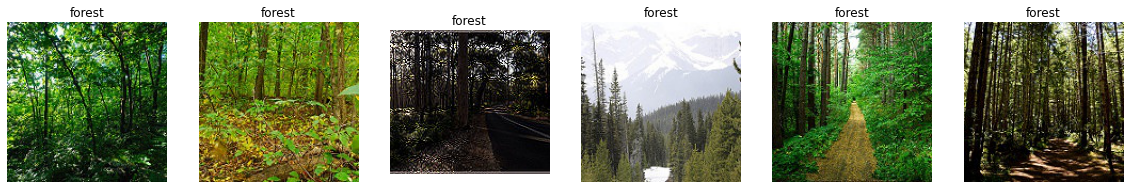

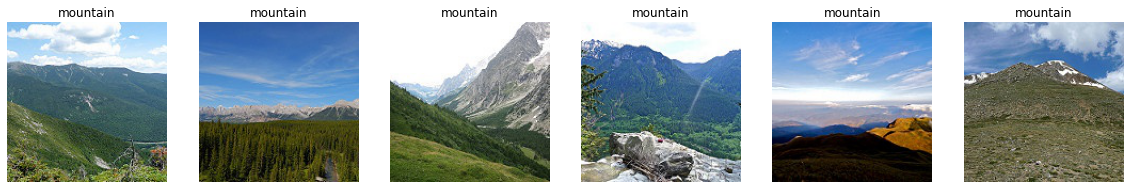

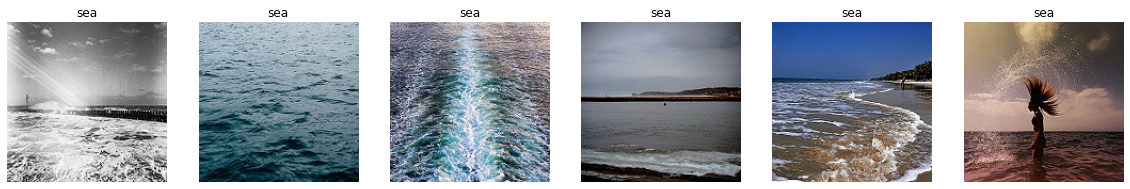

In [12]:
for c in classes:
    plot_images(c)

# 2. Prepare the data

In [13]:
BATCH_SIZE = 128
EPOCHS = 10

In [14]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=256, max_size=None, antialias=None),
    torchvision.transforms.CenterCrop(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=([0.4850, 0.4560, 0.4060]), std=([0.2290, 0.2240, 0.2250]))
])
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=256, max_size=None, antialias=None),
    torchvision.transforms.CenterCrop(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=([0.4850, 0.4560, 0.4060]), std=([0.2290, 0.2240, 0.2250]))
])

In [15]:
img = Image.open("/content/seg_pred/seg_pred/10004.jpg")
transform_train(img).shape

torch.Size([3, 224, 224])

In [16]:
train_data = torchvision.datasets.ImageFolder(train_dir, transform = transform_train)
test_data = torchvision.datasets.ImageFolder(test_dir, transform = transform_test)

train_loader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, BATCH_SIZE, shuffle=False)

# 3. Build the model

In [37]:
def model_assets(base_model, seed):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(base_model.parameters(), lr=0.001, momentum=0.9)
    lrp_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)
    return criterion, optimizer, lrp_scheduler

In [38]:
def model_archive(seed):
    if seed == 0:
        model = torchvision.models.vgg16_bn(pretrained=True)
        in_features = model.classifier[0].in_features
    elif seed == 1:
        model = torchvision.models.efficientnet_b0(pretrained=True)
        in_features = model.classifier[1].in_features
    elif seed == 2:
        model = torchvision.models.mobilenet_v3_small(pretrained=True)
        in_features = model.classifier[0].in_features
    # Freeze parametes in base_model
    for param in model.parameters():
        param.requires_grad=False

    model.classifier = nn.Sequential(
        nn.Linear(in_features, out_features=256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(in_features=256, out_features=128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(in_features=128, out_features=len(classes)),
    )
    model.to(device)
    criterion, optimizer, lrp_scheduler = model_assets(model, seed) 
    return model, criterion, optimizer, lrp_scheduler
    

In [39]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs, lrp_scheduler):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    train_acc = np.zeros(epochs)
    test_acc = np.zeros(epochs)
    start = datetime.now()
    for it in range(epochs):
        # Training part
        t0 = datetime.now()
        model.train()
        train_loss = []
        train_total = 0
        train_correct = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            _, train_predict = torch.max(outputs.data, 1)
            loss = criterion(outputs, targets)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_total += targets.size(0)
            train_correct += (train_predict == targets).sum().item()

        # Validating part
        model.eval()
        test_loss = []
        test_total = 0
        test_correct = 0
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, test_predict = torch.max(outputs.data, 1)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
            test_total += targets.size(0)
            test_correct += (test_predict == targets).sum().item()
        # get train and test loss
        test_loss = np.mean(test_loss)
        train_loss = np.mean(train_loss)

        lrp_scheduler.step(test_loss)

        print('learning_rate: {}'.format(optimizer.state_dict()['param_groups'][0]['lr']))

        train_losses[it] = train_loss
        test_losses[it] = test_loss
        train_acc[it] = 100*train_correct/train_total
        test_acc[it] = 100*test_correct/test_total
        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train_loss:{train_loss:.3f}, Train_accuracy:{(100*train_correct/train_total):.3f}, Test_loss:{test_loss:.3f}, Test_accuracy:{(100*test_correct/test_total):.3f}, Duration:{dt}')
    total_time = datetime.now() - start
    return train_losses, test_losses, train_acc, test_acc, total_time

In [40]:
# VGG16_bn
model_vgg, criterion_vgg, optimizer_vgg, lrp_scheduler_vgg = model_archive(seed = 0)
vgg_param = sum(p.numel() for p in model_vgg.parameters())
loss_train_vgg, loss_test_vgg, acc_train_vgg, acc_test_vgg, total_time_vgg = batch_gd(model_vgg, criterion_vgg, optimizer_vgg, train_loader, test_loader, EPOCHS, lrp_scheduler_vgg)

learning_rate: 0.001
Epoch 1/10, Train_loss:1.652, Train_accuracy:44.663, Test_loss:1.356, Test_accuracy:77.900, Duration:0:02:09.046545
learning_rate: 0.001
Epoch 2/10, Train_loss:1.004, Train_accuracy:80.782, Test_loss:0.653, Test_accuracy:86.833, Duration:0:02:09.081880
learning_rate: 0.001
Epoch 3/10, Train_loss:0.539, Train_accuracy:85.706, Test_loss:0.410, Test_accuracy:88.233, Duration:0:02:08.812119
learning_rate: 0.001
Epoch 4/10, Train_loss:0.387, Train_accuracy:88.321, Test_loss:0.330, Test_accuracy:89.400, Duration:0:02:08.805921
learning_rate: 0.001
Epoch 5/10, Train_loss:0.319, Train_accuracy:90.110, Test_loss:0.298, Test_accuracy:89.833, Duration:0:02:08.750420
learning_rate: 0.001
Epoch 6/10, Train_loss:0.281, Train_accuracy:91.022, Test_loss:0.276, Test_accuracy:90.233, Duration:0:02:08.773464
learning_rate: 0.001
Epoch 7/10, Train_loss:0.256, Train_accuracy:91.699, Test_loss:0.265, Test_accuracy:90.767, Duration:0:02:09.360208
learning_rate: 0.001
Epoch 8/10, Train_lo

In [41]:
del model_vgg
torch.cuda.empty_cache()

In [42]:
# EfficientNetB0
model_eff, criterion_eff, optimizer_eff, lrp_scheduler_eff = model_archive(seed = 1)
eff_param = sum(p.numel() for p in model_eff.parameters())
loss_train_eff, loss_test_eff, acc_train_eff, acc_test_eff, total_time_eff = batch_gd(model_eff, criterion_eff, optimizer_eff, train_loader, test_loader, EPOCHS, lrp_scheduler_eff)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

learning_rate: 0.001
Epoch 1/10, Train_loss:1.781, Train_accuracy:20.750, Test_loss:1.763, Test_accuracy:27.233, Duration:0:01:02.713778
learning_rate: 0.001
Epoch 2/10, Train_loss:1.748, Train_accuracy:36.176, Test_loss:1.716, Test_accuracy:52.667, Duration:0:01:02.407819
learning_rate: 0.001
Epoch 3/10, Train_loss:1.681, Train_accuracy:54.461, Test_loss:1.610, Test_accuracy:65.000, Duration:0:01:02.590381
learning_rate: 0.001
Epoch 4/10, Train_loss:1.528, Train_accuracy:64.543, Test_loss:1.376, Test_accuracy:71.467, Duration:0:01:02.671675
learning_rate: 0.001
Epoch 5/10, Train_loss:1.238, Train_accuracy:71.761, Test_loss:1.021, Test_accuracy:78.200, Duration:0:01:02.634021
learning_rate: 0.001
Epoch 6/10, Train_loss:0.928, Train_accuracy:76.308, Test_loss:0.763, Test_accuracy:82.100, Duration:0:01:02.300270
learning_rate: 0.001
Epoch 7/10, Train_loss:0.738, Train_accuracy:79.464, Test_loss:0.611, Test_accuracy:84.000, Duration:0:01:02.451142
learning_rate: 0.001
Epoch 8/10, Train_lo

In [43]:
del model_eff
torch.cuda.empty_cache()

In [44]:
# MobileNet_v3_small
model_mobile, criterion_mobile, optimizer_mobile, lrp_scheduler_mobile = model_archive(seed = 2)
mobile_param = sum(p.numel() for p in model_mobile.parameters())
loss_train_mobile, loss_test_mobile, acc_train_mobile, acc_test_mobile, total_time_mobile = batch_gd(model_mobile, criterion_mobile, optimizer_mobile, train_loader, test_loader, EPOCHS, lrp_scheduler_mobile)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

learning_rate: 0.001
Epoch 1/10, Train_loss:1.761, Train_accuracy:21.213, Test_loss:1.716, Test_accuracy:29.167, Duration:0:00:46.936509
learning_rate: 0.001
Epoch 2/10, Train_loss:1.631, Train_accuracy:44.592, Test_loss:1.498, Test_accuracy:65.967, Duration:0:00:46.550342
learning_rate: 0.001
Epoch 3/10, Train_loss:1.329, Train_accuracy:65.755, Test_loss:1.084, Test_accuracy:76.633, Duration:0:00:46.699944
learning_rate: 0.001
Epoch 4/10, Train_loss:0.954, Train_accuracy:72.602, Test_loss:0.778, Test_accuracy:80.267, Duration:0:00:46.491314
learning_rate: 0.001
Epoch 5/10, Train_loss:0.750, Train_accuracy:76.051, Test_loss:0.630, Test_accuracy:81.533, Duration:0:00:47.094704
learning_rate: 0.001
Epoch 6/10, Train_loss:0.634, Train_accuracy:79.022, Test_loss:0.542, Test_accuracy:83.833, Duration:0:00:46.629089
learning_rate: 0.001
Epoch 7/10, Train_loss:0.562, Train_accuracy:80.155, Test_loss:0.482, Test_accuracy:84.600, Duration:0:00:46.681083
learning_rate: 0.001
Epoch 8/10, Train_lo

In [46]:
del model_mobile
torch.cuda.empty_cache()

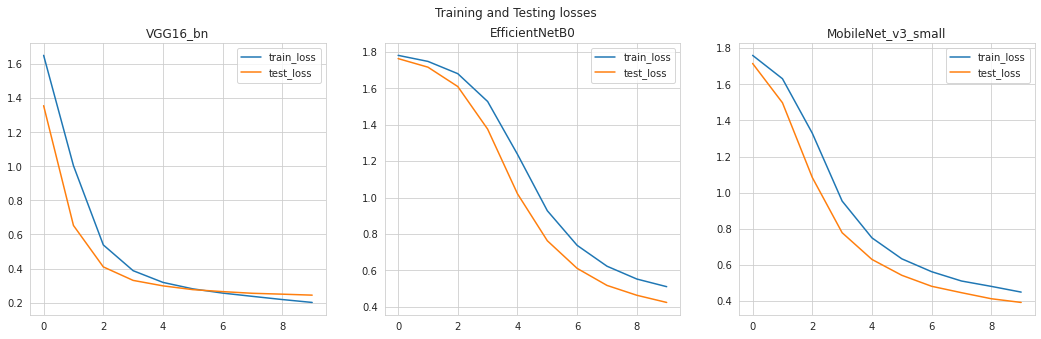

In [65]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Training and Testing losses')
axes[0].plot(loss_train_vgg, label='train_loss')
axes[0].plot(loss_test_vgg, label='test_loss')
axes[0].set_title('VGG16_bn')
axes[0].legend()

axes[1].plot(loss_train_eff, label='train_loss')
axes[1].plot(loss_test_eff, label='test_loss')
axes[1].set_title('EfficientNetB0')
axes[1].legend()

axes[2].plot(loss_train_mobile, label='train_loss')
axes[2].plot(loss_test_mobile, label='test_loss')
axes[2].set_title('MobileNet_v3_small')
axes[2].legend()

plt.show()

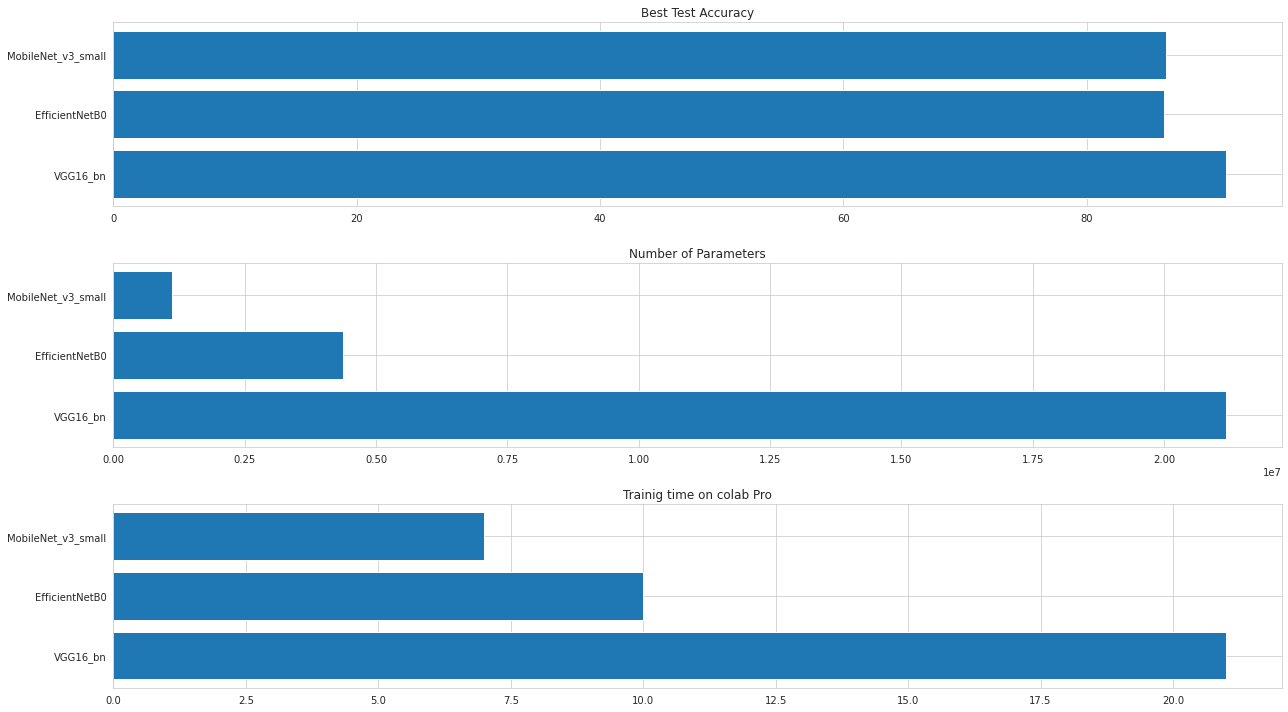

In [63]:
fig, axes = plt.subplots(3, 1, figsize=(18, 10))

axes[0].barh(['VGG16_bn','EfficientNetB0','MobileNet_v3_small'], [max(acc_test_vgg), max(acc_test_eff), max(acc_test_mobile)])
axes[0].set_title('Best Test Accuracy')
axes[1].barh(['VGG16_bn','EfficientNetB0','MobileNet_v3_small'], [vgg_param, eff_param, mobile_param])
axes[1].set_title('Number of Parameters')
axes[2].barh(['VGG16_bn','EfficientNetB0','MobileNet_v3_small'], [int(total_time_vgg.total_seconds()//60), int(total_time_eff.total_seconds()//60), int(total_time_mobile.total_seconds()//60)])
axes[2].set_title('Trainig time on colab Pro')

fig.tight_layout()
plt.show()